#Major 3

##Part 0

In [ ]:
from matplotlib import pylab
params = {'xtick.labelsize': 18,
          'ytick.labelsize': 18,
          'axes.titlesize' : 22,
          'axes.labelsize' : 20,
          'legend.fontsize': 18,
          'legend.title_fontsize': 22,
          'figure.titlesize': 24 }
pylab.rcParams.update(params)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sys import stdlib_module_names
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [ ]:
!rm *.csv
from google.colab import files
uploadedData = files.upload()
filename = list(uploadedData)[0]
dataset = pd.read_csv(filename)

Saving data_HW3.csv to data_HW3.csv


In [ ]:
ds = dataset.copy()
df = pd.DataFrame(ds)
train_data, test_data = train_test_split(df, test_size=0.2, random_state=96)

In [ ]:
def prepare_data(training_data, new_data):
    train = training_data.copy()
    res = new_data.copy()

    median = train.household_income.median()
    res['household_income'].fillna(median, inplace = True)

    res['SpecialProperty'] = res['blood_type'].isin(['O+','B+'])
    res.drop(columns=['blood_type', 'pcr_date', 'current_location', 'patient_id', 'sex'],inplace = True)

    min_max_norm = ['PCR_03', 'PCR_10']
    std_norm = ['sugar_levels', 'PCR_01','PCR_02','PCR_04','PCR_05','PCR_06','PCR_07','PCR_08','PCR_09']

    min_max_scalar = MinMaxScaler((-1,1), copy = False)
    std_scalar = StandardScaler()

    min_max_scalar.fit(train[min_max_norm])
    std_scalar.fit(train[std_norm])

    res[min_max_norm] = min_max_scalar.transform(res[min_max_norm])
    res[std_norm] = std_scalar.transform(res[std_norm])

    return res

In [ ]:
train_data = prepare_data(train_data, train_data)
test_data = prepare_data(train_data, test_data)
print(test_data.columns)

Index(['age', 'weight', 'num_of_siblings', 'happiness_score',
       'household_income', 'conversations_per_day', 'sugar_levels',
       'sport_activity', 'PCR_01', 'PCR_02', 'PCR_03', 'PCR_04', 'PCR_05',
       'PCR_06', 'PCR_07', 'PCR_08', 'PCR_09', 'PCR_10', 'contamination_level',
       'SpecialProperty'],
      dtype='object')


#Section 1

In [ ]:
train_data_sec1, validation_data_sec1 = train_test_split(train_data, test_size=0.2, random_state=96)
print(train_data_sec1.columns)

Index(['age', 'weight', 'num_of_siblings', 'happiness_score',
       'household_income', 'conversations_per_day', 'sugar_levels',
       'sport_activity', 'PCR_01', 'PCR_02', 'PCR_03', 'PCR_04', 'PCR_05',
       'PCR_06', 'PCR_07', 'PCR_08', 'PCR_09', 'PCR_10', 'contamination_level',
       'SpecialProperty'],
      dtype='object')


In [ ]:
from sklearn.base import BaseEstimator, RegressorMixin
import numpy as np

class LinearRegressor(BaseEstimator, RegressorMixin):
  """
  Custom linear regression model
  """
  def __init__(self, lr: float = 1e-5):
      """
      Initialize an instance of this class.
      * Do not edit this method *

      :param lr: the SGD learning rate (step size)
      """
      self.lr = lr
      self.batch_size = 32
      self.w = None
      self.b = 0.0

  # Initialize a random weight vector
  def init_solution(self, n_features: int):
      """
      Randomize an initial solution (weight vector)
      * Do not edit this method *

      :param n_features:
      """
      self.w = np.zeros(n_features)
      self.b = 0.0

  @staticmethod
  def loss(w, b: float, X, y):
      """
      Compute the MSE objective loss.

      :param w: weight vector for linear regression; array of shape (n_features,)
      :param b: bias scalar for linear regression
      :param X: samples for loss computation; array of shape (n_samples, n_features)
      :param y: targets for loss computation; array of shape (n_samples,)
      :return: the linear regression objective loss (float scalar)
      """
      m = np.shape(w)[0]
      # TODO: complete the loss calculation
      loss = (np.linalg.norm(X@w + b - y)**2)/m
      return loss

  @staticmethod
  def gradient(w, b: float, X, y):
      """
      Compute the (analytical) linear regression objective gradient.

      :param w: weight vector for linear regression; array of shape (n_features,)
      :param b: bias scalar for linear regression
      :param X: samples for loss computation; array of shape (n_samples, n_features)
      :param y: targets for loss computation; array of shape (n_samples,)
      :return: a tuple with (the gradient of the weights, the gradient of the bias)
      """
      # TODO: calculate the analytical gradient w.r.t w and b
      m = np.shape(w)[0]
      ls = (X@w + b - y)
      g_w = 2*np.transpose(X)@ls/m
      g_b = 2*np.sum(X@w + b - y)/m
      return g_w, g_b

  def fit_with_logs(self, X, y, max_iter: int = 1000, keep_losses: bool = True,
                    X_val  =None, y_val = None):
      """
      Fit the model according to the given training data.

      :param X: training samples; array of shape (n_samples, n_features)
      :param y: training targets; array of shape (n_samples,)
      :param max_iter: number of SGD iterations
      :param keep_losses: should compute the train & val losses during training?
      :param X_val: validation samples to compute the loss for (for logs only)
      :param y_val: validation labels to compute the loss for (for logs only)
      :return: training and validation losses during training
      """
      # Initialize learned parameters
      self.init_solution(X.shape[1])

      train_losses = []
      val_losses = []

      if keep_losses:
          train_losses.append(self.loss(self.w, self.b, X, y))
          val_losses.append(self.loss(self.w, self.b, X_val, y_val))

      # Iterate over batches (SGD)
      for itr in range(0, max_iter):
          start_idx = (itr * self.batch_size) % X.shape[0]
          end_idx = min(X.shape[0], start_idx + self.batch_size)
          batch_X = X[start_idx: end_idx]
          batch_y = y[start_idx: end_idx]

          # TODO: Compute the gradient for the current batch
          g_w, g_b = self.gradient(self.w, self.b, batch_X, batch_y)

          # Perform a gradient step
          # TODO: update the learned parameters correctly
          self.w = self.w-self.lr*g_w
          self.b = self.b-self.lr*g_b

          if keep_losses:
              train_losses.append(self.loss(self.w, self.b,  X, y))
              val_losses.append(self.loss(self.w, self.b,  X_val, y_val))

      return train_losses, val_losses

  def fit(self, X, y, max_iter: int = 1000):
      """
      Fit the model according to the given training data.
      * Do not edit this method *

      :param X: training samples; array of shape (n_samples, n_features)
      :param y: training targets; array of shape (n_samples,)
      :param max_iter: number of SGD iterations
      """
      self.fit_with_logs(X, y, max_iter=max_iter, keep_losses=False)

      return self

  def predict(self, X):
      """
      Regress labels on samples in X.

      :param X: samples for prediction; array of shape (n_samples, n_features)
      :return: Predicted continuous labels for samples in X; array of shape (n_samples,)
      """

      # TODO: Compute
      y_pred = X@self.w + self.b

      return y_pred

In [ ]:
def numerical_subgradient(w, b, X, y, delta=1e-4):
    w_ = w.copy()
    g_w = np.zeros_like(w_)
    orig_objective = LinearRegressor.loss(w_, b, X, y)
    for i in range(g_w.shape[0]):
        w_[i] += delta
        perturbed_objective = LinearRegressor.loss(w_, b, X, y)
        w_[i] -= delta
        g_w[i] = (perturbed_objective - orig_objective) / delta

    g_b = (LinearRegressor.loss(w_, b + delta, X, y) - orig_objective) / delta
    return g_w, g_b


def compare_gradients(X, y, deltas, C=1, REPEATS=10, figsize=(10, 6)):
    residual_means_w = []
    residual_means_b = []

    for delta in deltas:
        residuals_w = []
        residuals_b = []

        for _ in range(REPEATS):
            # Randomize vectors in which the gradient is computed
            w = np.random.randn(X.shape[1])
            b = np.random.randn(1)

            # Compute the two types of gradients
            analytic_grad_w, analytic_grad_b = LinearRegressor.gradient(w, b, X, y)

            numeric_grad_w, numeric_grad_b = numerical_subgradient(w, b, X, y, delta=delta)

            residual_w = np.linalg.norm(numeric_grad_w - analytic_grad_w)
            residuals_w.append(residual_w)

            residual_b = np.linalg.norm(numeric_grad_b - analytic_grad_b)
            residuals_b.append(residual_b)

        residual_means_w.append(np.mean(residuals_w))
        residual_means_b.append(np.mean(residuals_b))

    fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(16, 8))
    plt.suptitle('Residuals of analytical and numerical gradients',
                 fontsize=22, fontweight="bold")
    axs[0].set_title(r'Residuals of $\nabla_{w}L\left(w,b\right)$')
    axs[1].set_title(r'Residuals of $\frac{\partial}{\partial{b}}L\left(w,b\right)$')
    axs[0].plot(deltas, residual_means_w, linewidth=3)
    axs[1].plot(deltas, residual_means_b, linewidth=3)
    axs[0].set_yscale('log')
    axs[0].set_xscale('log')
    axs[1].set_yscale('log')
    axs[1].set_xscale('log')
    axs[0].set_xlabel('$\delta_w$', fontsize=18)
    axs[1].set_xlabel('$\delta_b$', fontsize=18)
    axs[0].set_ylabel(r'$\left\Vert \nabla_{w}L\left(w,b\right) - u_{\delta_w} \left(w,b\right)\right\Vert$',
                      fontsize=18)
    axs[1].set_ylabel(
        r'$\left\Vert \frac{\partial}{\partial{b}}L\left(w,b\right) - u_{\delta_b} \left(w,b\right)\right\Vert$',
        fontsize=18)

    axs[0].grid(alpha=0.5)
    axs[1].grid(alpha=0.5)
    plt.show()

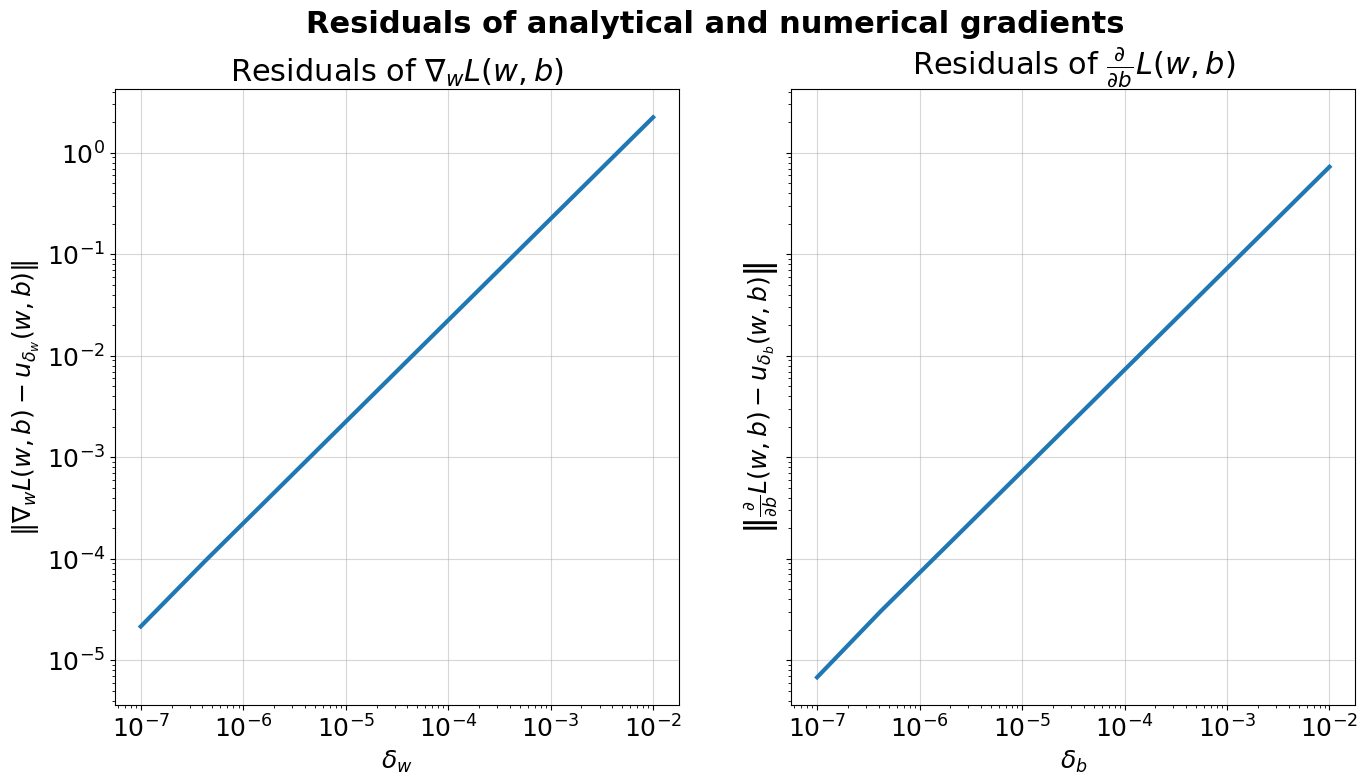

In [ ]:
X_train_sec1 = train_data_sec1[train_data_sec1.columns[train_data_sec1.columns.str.contains('PCR') | (train_data_sec1.columns == 'sugar_levels')]].to_numpy()
y_train_sec1 = train_data_sec1['contamination_level'].to_numpy()
compare_gradients(X_train_sec1, y_train_sec1, deltas=np.logspace(-7, -2, 9))

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def test_lr(X_train, y_train, X_val, y_val, title:str, max_iter = 1500):
  lr_list = np.logspace(-9, -1, 9)

  fig, axs = plt.subplots(3, 3, sharey=True, figsize=(20, 12))
  plt.suptitle(title, fontsize=32)
  plt.tight_layout()
  fig.subplots_adjust(hspace=0.5, top=0.9)

  axs = np.ravel(axs)
  for i, lr in enumerate(lr_list):
    cur_linear_reggressor = LinearRegressor(lr)
    train_losses, val_losses = cur_linear_reggressor.fit_with_logs(X_train, y_train, keep_losses=True, X_val=X_val, y_val=y_val, max_iter = max_iter)
    print('lr size = '+str(lr)+', Best train loss = '+str(min(train_losses))+', Best validation loss = '+str(min(val_losses)))

    iterations = np.arange(max_iter + 1)
    axs[i].semilogy(iterations, train_losses, label="Train")
    axs[i].semilogy(iterations, val_losses, label="Validation")
    axs[i].grid(alpha=0.5)
    axs[i].legend()
    axs[i].set_title('lr = '+str(lr))
    axs[i].set_xlabel('iteration')
    axs[i].set_ylabel('MSE')

lr size = 1e-09, Best train loss = 5.621520478925133, Best validation loss = 1.4087912073700208
lr size = 1e-08, Best train loss = 5.620732925084874, Best validation loss = 1.408596557618204
lr size = 1e-07, Best train loss = 5.612864127311429, Best validation loss = 1.4066517216447005
lr size = 1e-06, Best train loss = 5.534846302962507, Best validation loss = 1.3873685593554894
lr size = 1e-05, Best train loss = 4.817940914662674, Best validation loss = 1.2101401724151217
lr size = 0.0001, Best train loss = 1.446136780881097, Best validation loss = 0.3766504714395799
lr size = 0.001, Best train loss = 0.5078358277770548, Best validation loss = 0.15013344285189845
lr size = 0.01, Best train loss = 0.508229717973801, Best validation loss = 0.14791003436298927
lr size = 0.1, Best train loss = 0.5451730516093238, Best validation loss = 0.15340400749021918


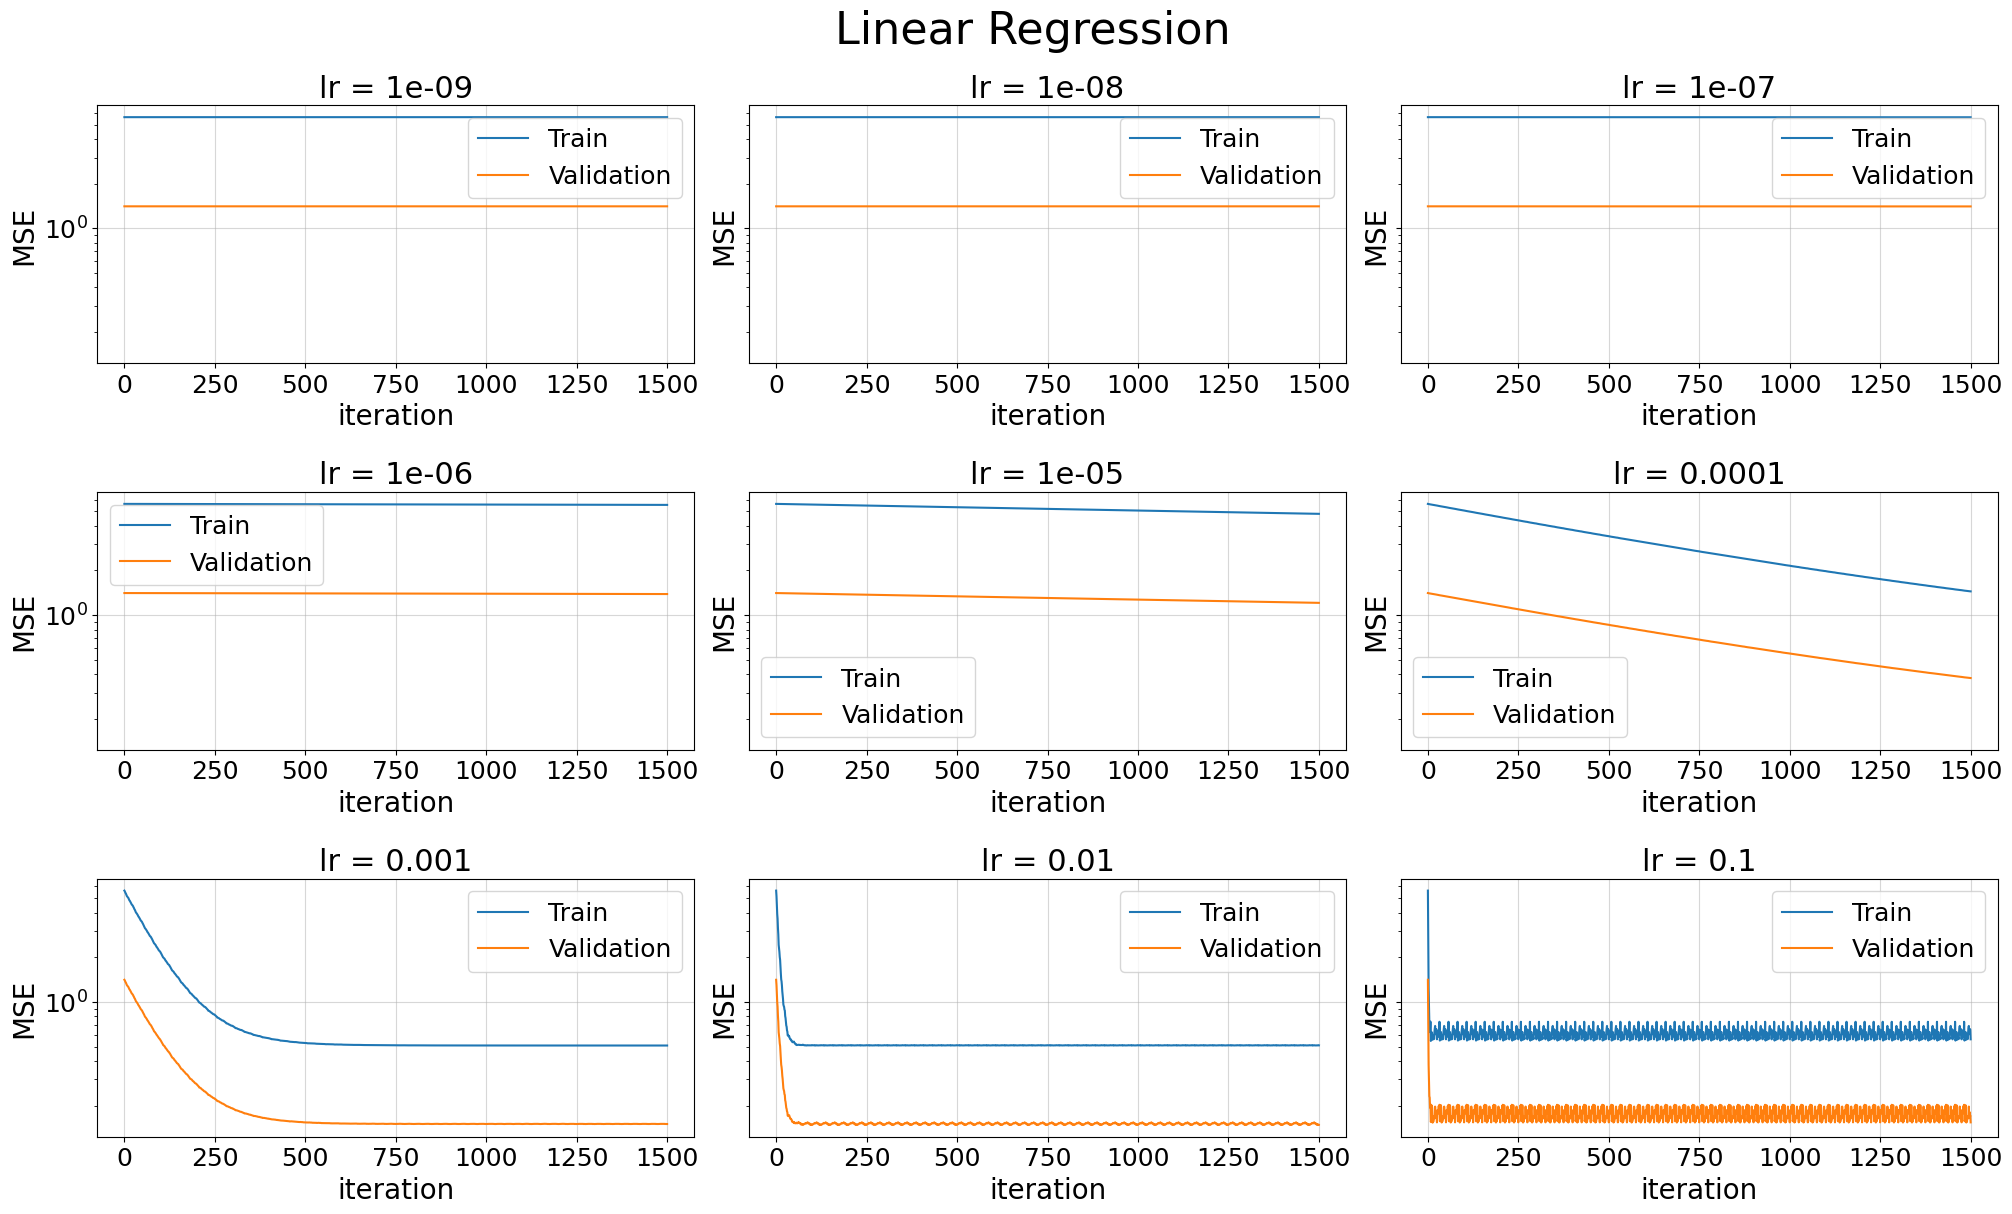

In [ ]:
X_val_sec1 = validation_data_sec1[validation_data_sec1.columns[validation_data_sec1.columns.str.contains('PCR') | (validation_data_sec1.columns == 'sugar_levels')]].to_numpy()
y_val_sec1 = validation_data_sec1['contamination_level'].to_numpy()
test_lr(X_train_sec1, y_train_sec1, X_val_sec1, y_val_sec1, 'Linear Regression')

#Section 2

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyRegressor
from sklearn.neighbors import KNeighborsClassifier

X_train = train_data[['PCR_01', 'PCR_02', 'PCR_03', 'PCR_04', 'PCR_05', 'PCR_06', 'PCR_09', 'PCR_10', 'sugar_levels']]
y_train = train_data['contamination_level']

dummy_regr = DummyRegressor(strategy="mean")
dummy_results = cross_validate(dummy_regr, X_train, y_train, cv=5, return_train_score = True, scoring='neg_mean_squared_error')

train_mse = -dummy_results['train_score'].mean()
validation_mse = -dummy_results['test_score'].mean()
print(f"CV Training MSE of Dummy Regressor: {train_mse:.4f}")
print(f"CV Validation MSE of Dummy Regressor: {validation_mse:.4f}")

CV Training MSE of Dummy Regressor: 0.0684
CV Validation MSE of Dummy Regressor: 0.0685


In [ ]:
dummy_regressor_sec6 = DummyRegressor(strategy="mean")
dummy_regressor_sec6.fit(X_train, y_train)

DummyRegressor()

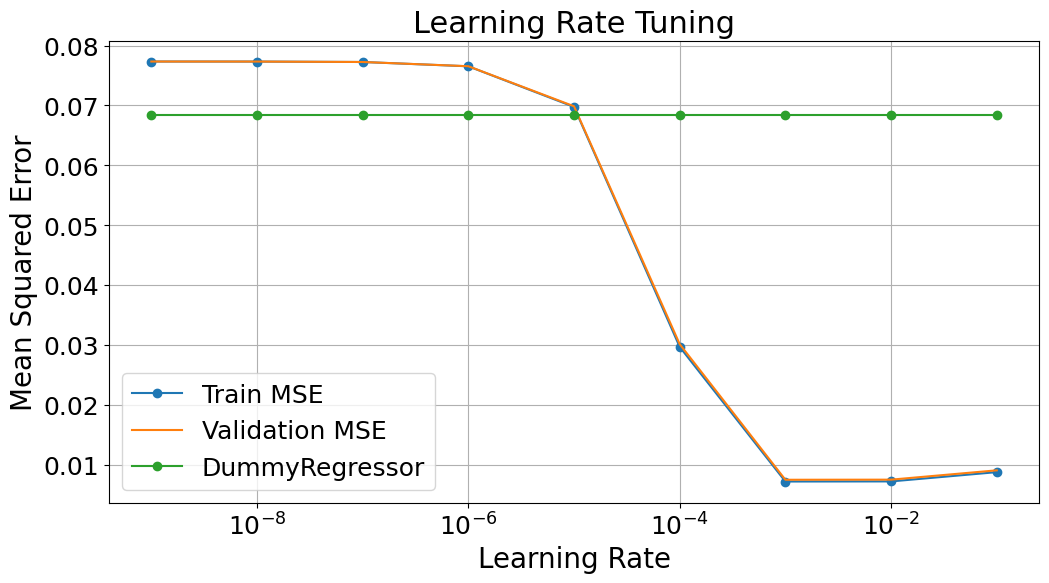

In [ ]:
import matplotlib.pyplot as plt

lr_list = np.logspace(-9, -1, 9)
train_results = []
val_results = []

X_train_copy = train_data[train_data.columns[train_data.columns.str.contains('PCR') | (train_data.columns == 'sugar_levels')]]
X_train_np = X_train_copy.copy().to_numpy()
y_train_copy = train_data['contamination_level']
y_train_np = y_train_copy.copy().to_numpy()
for lr in lr_list:
  customLR = LinearRegressor(lr)
  results = cross_validate(customLR, X_train_np, y_train_np, return_train_score = True, scoring='neg_mean_squared_error')
  train_results.append(-results['train_score'].mean())
  val_results.append(-results['test_score'].mean())

plt.figure(figsize=(12, 6))
plt.semilogx(lr_list, train_results, marker='o', label='Train MSE')
plt.semilogx(lr_list, val_results, label='Validation MSE')
plt.semilogx(lr_list, [-dummy_results['train_score'].mean()]*len(lr_list), label='DummyRegressor', marker = 'o')
plt.xlabel('Learning Rate')
plt.ylabel('Mean Squared Error')
plt.title('Learning Rate Tuning')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
optimal_lr = lr_list[np.argmin(train_results)]
print(f"Optimal Learning Rate: {optimal_lr:.3f}")
optimalRegressor = LinearRegressor(optimal_lr)
scores = cross_validate(optimalRegressor, X_train_np, y_train_np, return_train_score = True, scoring='neg_mean_squared_error')

print(f"CV Training MSE of Linear Regressor: {-scores['train_score'].mean():.4f}")
print(f"CV Validation MSE of Linear Regressor: {-scores['test_score'].mean():.4f}")

Optimal Learning Rate: 0.001
CV Training MSE of Linear Regressor: 0.0072
CV Validation MSE of Linear Regressor: 0.0075


In [ ]:
linear_regressor_sec6 = LinearRegressor(optimal_lr)
linear_regressor_sec6.fit(X_train, y_train)

LinearRegressor(lr=0.001)

#Section 3

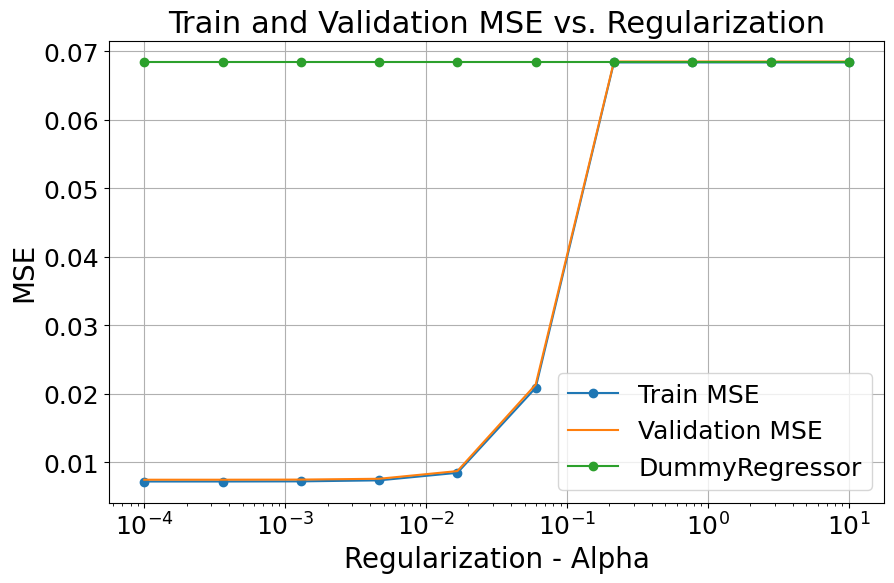

In [ ]:
from sklearn.linear_model import Lasso
alphas = np.logspace(-4, 1, 10)
X_train_np = X_train.copy().to_numpy()
y_train_np = y_train.copy().to_numpy()
train_mse_scores = []
val_mse_scores = []
for alpha in alphas:
    lasso_regr = Lasso(alpha=alpha, fit_intercept=True)
    results = cross_validate(lasso_regr, X_train,y_train, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
    train_mse_scores.append(-results['train_score'].mean())
    val_mse_scores.append(-results['test_score'].mean())

plt.figure(figsize=(10, 6))
plt.semilogx(alphas, train_mse_scores, label='Train MSE', marker = 'o')
plt.semilogx(alphas, val_mse_scores, label='Validation MSE')
plt.semilogx(alphas, [-dummy_results['train_score'].mean()]*len(alphas), label='DummyRegressor', marker = 'o')
plt.xlabel('Regularization - Alpha')
plt.ylabel('MSE')
plt.title('Train and Validation MSE vs. Regularization')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
optimal_alpha = alphas[np.argmin(val_mse_scores)]
print(f'Optimal Alpha: {optimal_alpha}')
print(f'Validation MSE at Optimal Alpha: {min(val_mse_scores)}')
print(f'Train MSE at Optimal Alpha: {min(train_mse_scores)}')

Optimal Alpha: 0.0001
Validation MSE at Optimal Alpha: 0.007459311712823732
Train MSE at Optimal Alpha: 0.007197391325082718


In [ ]:
lasso_regressor_sec6 = Lasso(alpha=optimal_alpha, fit_intercept=True)
lasso_regressor_sec6.fit(X_train, y_train)

Lasso(alpha=0.0001)

In [ ]:
feature_names = list(X_train.columns)
coefficients = lasso_regressor_sec6.coef_
abs_coefficients = np.abs(coefficients)
sorted_indices = np.argsort(abs_coefficients)[::-1]
top_5_indices = sorted_indices[:5]
top_5_features = [(feature_names[i], coefficients[i]) for i in top_5_indices]
print("Top 5 Features by Coefficient (in absolute value):")
for name, coef in top_5_features:
    print(f"{name}: {abs(coef)}")

Top 5 Features by Coefficient (in absolute value):
PCR_04: 0.1956412184899808
sugar_levels: 0.12544346547463578
PCR_02: 0.08112083017999656
PCR_06: 0.047532067645830366
PCR_03: 0.008713816622654556


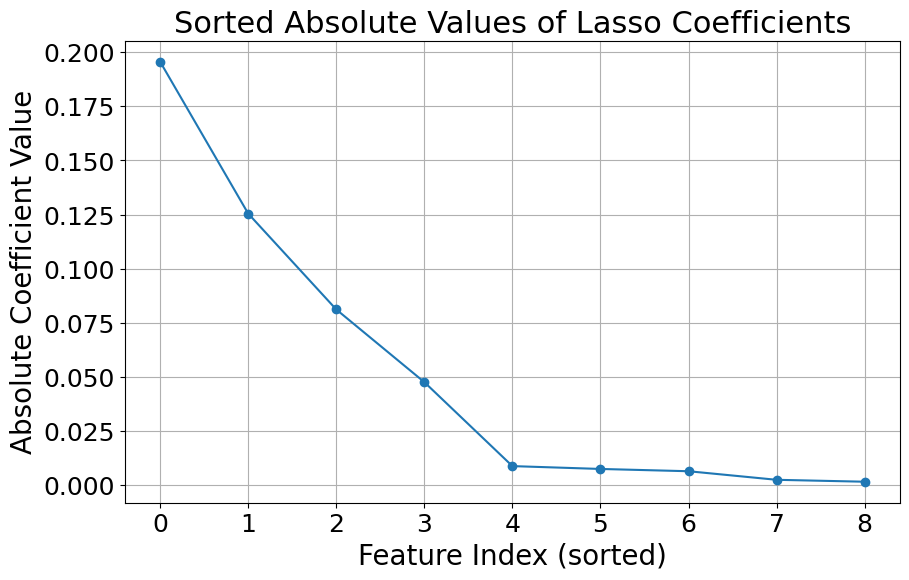

In [ ]:
sorted_coefs = np.sort(np.abs(lasso_regressor_sec6.coef_))[::-1]

plt.figure(figsize=(10, 6))
plt.plot(range(len(sorted_coefs)), sorted_coefs, marker='o')
plt.xlabel('Feature Index (sorted)')
plt.ylabel('Absolute Coefficient Value')
plt.title('Sorted Absolute Values of Lasso Coefficients')
plt.grid(True)
plt.show()

#Section 4

In [ ]:
def plot3d(df, colX:str, colY:str, colZ:str, title:str, predictions=None):
  fig = plt.figure(figsize=(20, 7))
  axes = [fig.add_subplot(1, 3, i+1, projection='3d') for i in range(3)]

  palette = sns.color_palette("hls", 2)

  for i,ax in enumerate(axes):
    if predictions is not None:
      ax.scatter3D(df[colX], df[colY], predictions, color=palette[1], s=3)
      ax.scatter3D(df[colX], df[colY], df[colZ], color=palette[0], s=1,
                   alpha=0.35, depthshade=False)
    else:
      ax.scatter3D(df[colX], df[colY], df[colZ], color=palette[0], s=1)

    ax.set_xlabel(colX)
    ax.set_ylabel(colY)
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])

    ax.view_init(elev=5., azim=45*i)

  axes[0].set_zlabel("\n" + colZ, linespacing=2.2)

  plt.suptitle(title, fontsize=32)
  plt.tight_layout()
  plt.show()

<ipython-input-395-8d1e5cb89966>:25: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


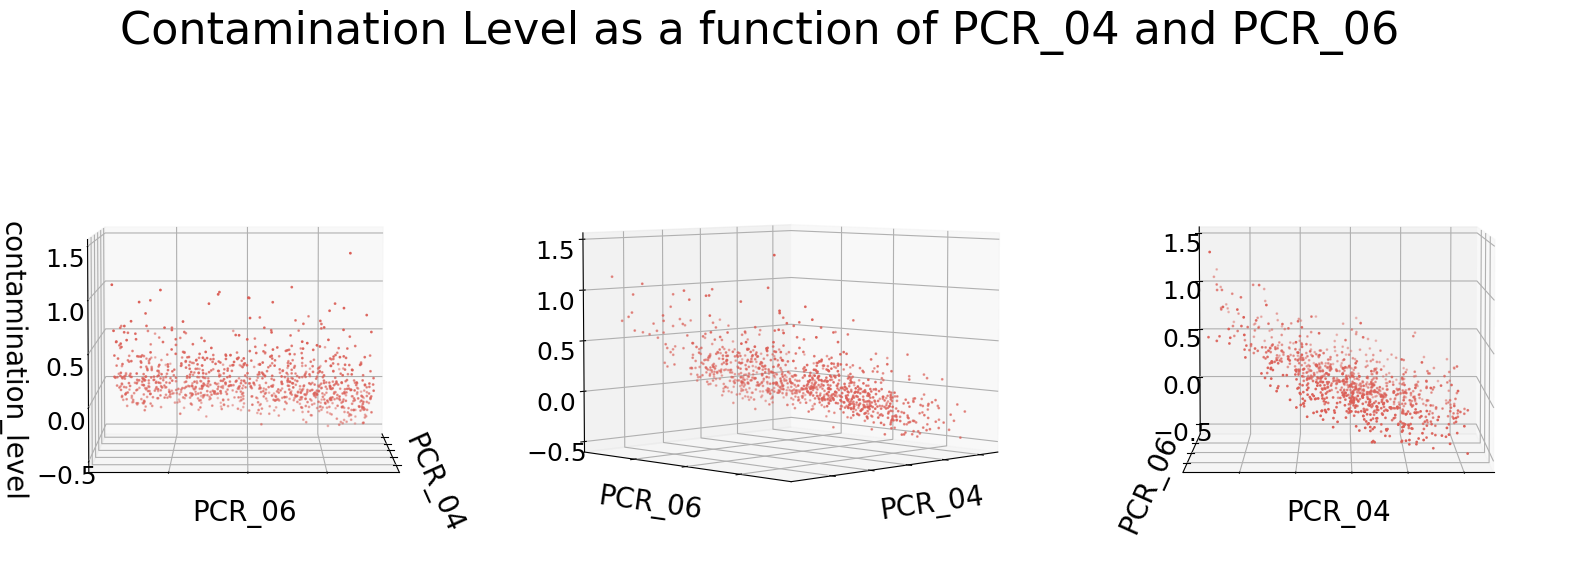

In [ ]:
subset_train_data = train_data[['PCR_04','PCR_06', 'contamination_level']]
plot3d(subset_train_data , 'PCR_04', 'PCR_06', 'contamination_level', 'Contamination Level as a function of PCR_04 and PCR_06')

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
poly_reg = Pipeline([('feature_mapping', PolynomialFeatures(degree = 4)),
('normalization', MinMaxScaler()),
('Lasso', Lasso(alpha=0.1, fit_intercept=True))])

In [ ]:
from sklearn.model_selection import GridSearchCV
alpha_values = np.logspace(-3, 0, 10)
param_grid = {
    'Lasso__alpha': alpha_values
}
X_train_sub = subset_train_data[['PCR_04', 'PCR_06']].copy()
y_train_sub = subset_train_data['contamination_level'].copy()
grid_search = GridSearchCV(poly_reg, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_sub, y_train_sub)

best_alpha = grid_search.best_params_['Lasso__alpha']
best_score = -grid_search.best_score_
print(f"Best Alpha: {best_alpha}")
print(f"Best Validation Error (MSE): {best_score:.2f}")

Best Alpha: 0.001
Best Validation Error (MSE): 0.02


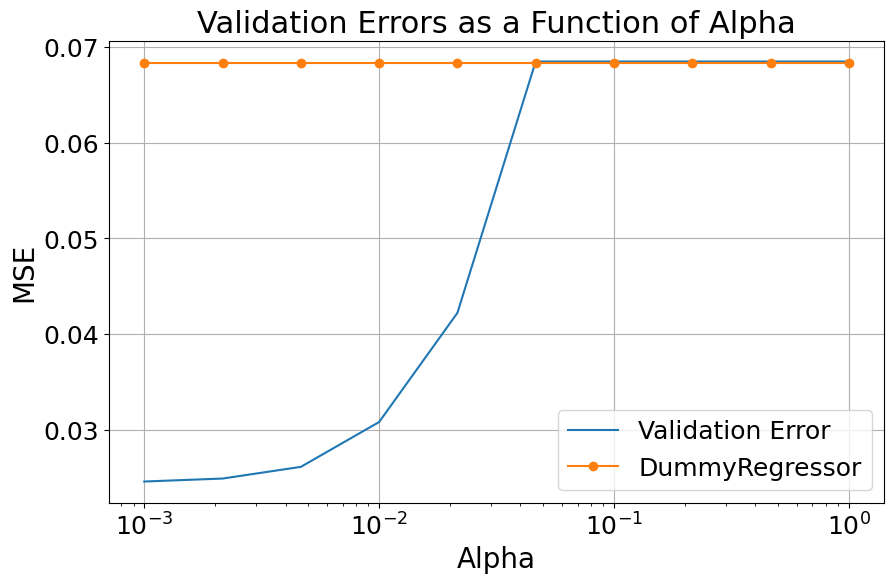

Optimal Alpha: 0.001
Validation Error (MSE) at Optimal Alpha: 0.0246


In [ ]:
validation_errors = -grid_search.cv_results_['mean_test_score']

plt.figure(figsize=(10, 6))
plt.semilogx(alpha_values, validation_errors, label='Validation Error')
plt.semilogx(alpha_values, [-dummy_results['train_score'].mean()]*len(alpha_values), label='DummyRegressor', marker = 'o')
plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.title('Validation Errors as a Function of Alpha')
plt.legend()
plt.grid(True)
plt.show()

best_alpha = grid_search.best_params_['Lasso__alpha']
best_score = -grid_search.best_score_

print(f"Optimal Alpha: {best_alpha}")
print(f"Validation Error (MSE) at Optimal Alpha: {best_score:.4f}")

In [ ]:
best_alpha = grid_search.best_params_['Lasso__alpha']
poly_lasso_sec6 = Pipeline([
    ('feature_mapping', PolynomialFeatures(degree=4, include_bias=False)),
    ('normalization', MinMaxScaler()),
    ('Lasso', Lasso(alpha=best_alpha, fit_intercept=True))
])

X_train_sub = subset_train_data[['PCR_04', 'PCR_06']]
y_train_sub = subset_train_data['contamination_level']
poly_lasso_sec6.fit(X_train, y_train)

Pipeline(steps=[('feature_mapping',
                 PolynomialFeatures(degree=4, include_bias=False)),
                ('normalization', MinMaxScaler()),
                ('Lasso', Lasso(alpha=0.001))])

<ipython-input-395-8d1e5cb89966>:25: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


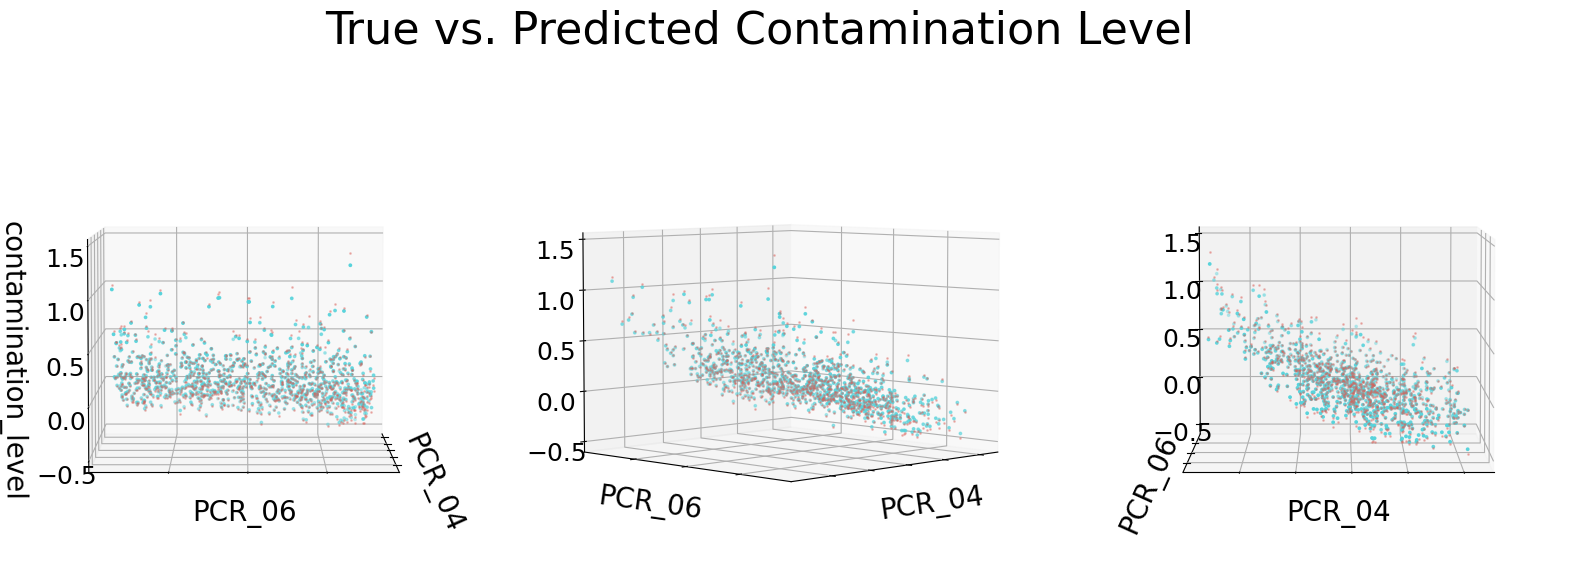

In [ ]:
y_pred = poly_lasso_sec6.predict(X_train)

plot_data = pd.DataFrame({
    'PCR_04': X_train['PCR_04'],
    'PCR_06': X_train['PCR_06'],
    'contamination_level': y_train,
    'predictions': y_train
})

plot3d(plot_data, colX='PCR_04', colY='PCR_06', colZ='contamination_level',
       title='True vs. Predicted Contamination Level', predictions=y_pred)

In [ ]:
from sklearn.metrics import mean_squared_error
train_mse = mean_squared_error(y_train, y_pred)

validation_mse = -grid_search.best_score_

print(f"Train MSE: {train_mse:.4f}")
print(f"Validation MSE: {validation_mse:.4f}")

Train MSE: 0.0003
Validation MSE: 0.0246


#Section 5

In [ ]:
features = ['PCR_01', 'PCR_02', 'PCR_03', 'PCR_04', 'PCR_05', 'PCR_06', 'PCR_09', 'PCR_10', 'sugar_levels']

X_train_gbm = train_data[features].copy()
y_train_gbm = train_data['contamination_level'].copy()

X_test_gbm = test_data[features].copy()
y_test_gbm = test_data['contamination_level'].copy()

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
param_grid = {
    'gbm__learning_rate': [0.01, 0.1, 0.3, 0.6, 1, 10],
    'gbm__min_samples_leaf': [1, 2, 5, 10,50]
}

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('gbm', GradientBoostingRegressor(loss='huber', n_estimators=100, max_depth=3, random_state=42))
])

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train_gbm, y_train_gbm)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:990: RuntimeWarning: overflow encountered in square
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('gbm',
                                        GradientBoostingRegressor(loss='huber',
                                                                  random_state=42))]),
             param_grid={'gbm__learning_rate': [0.01, 0.1, 0.3, 0.6, 1, 10],
                         'gbm__min_samples_leaf': [1, 2, 5, 10, 50]},
             scoring='neg_mean_squared_error', verbose=1)

In [ ]:
best_params = grid_search.best_params_
best_train_score = -grid_search.best_score_
best_validation_score = -grid_search.cv_results_['mean_test_score'][grid_search.best_index_]

print(f"Best Parameters: {best_params}")
print(f"Best Training Error (MSE): {best_train_score:.5f}")
print(f"Best Validation Error (MSE): {best_validation_score:.5f}")

Best Parameters: {'gbm__learning_rate': 0.1, 'gbm__min_samples_leaf': 5}
Best Training Error (MSE): 0.00128
Best Validation Error (MSE): 0.00128


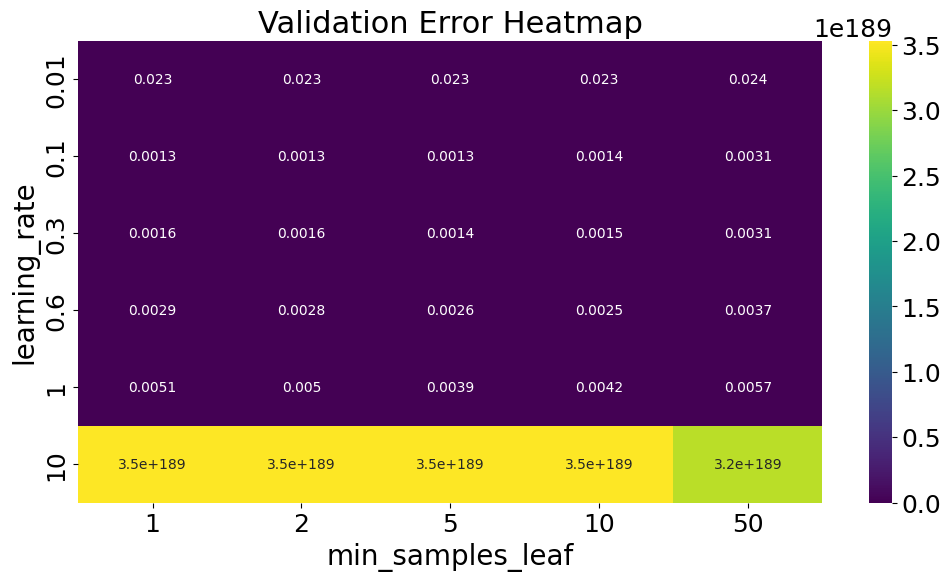

In [ ]:
results = grid_search.cv_results_
mean_test_scores = np.array(results['mean_test_score']).reshape(len(param_grid['gbm__learning_rate']), len(param_grid['gbm__min_samples_leaf']))

plt.figure(figsize=(12, 6))

sns.heatmap(-mean_test_scores, annot=True, cmap='viridis', xticklabels=param_grid['gbm__min_samples_leaf'], yticklabels=param_grid['gbm__learning_rate'])
plt.xlabel('min_samples_leaf')
plt.ylabel('learning_rate')
plt.title('Validation Error Heatmap')
plt.show()

In [ ]:
best_gbm = grid_search.best_estimator_
cv_results = cross_validate(best_gbm, X_train, y_train, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
train_errors = -cv_results['train_score']
val_errors = -cv_results['test_score']
mean_train_error = train_errors.mean()
mean_val_error = val_errors.mean()

print(f"Train MSE: {mean_train_error:.5f}")
print(f"Validation MSE: {mean_val_error:.5f}")

Train MSE: 0.00037
Validation MSE: 0.00128


In [ ]:
print("Best parameters found:", grid_search.best_params_)

Best parameters found: {'gbm__learning_rate': 0.1, 'gbm__min_samples_leaf': 5}


In [ ]:
best_params = grid_search.best_params_

final_gbm_sec6 = GradientBoostingRegressor(
    loss='huber',
    learning_rate=best_params['gbm__learning_rate'],
    min_samples_leaf=best_params['gbm__min_samples_leaf'],
    n_estimators=100,
    max_depth=3,
    random_state=42
)

final_gbm_sec6.fit(X_train, y_train)

GradientBoostingRegressor(loss='huber', min_samples_leaf=5, random_state=42)

#Section 6

In [ ]:
from sklearn.metrics import mean_squared_error

X_test = test_data[['PCR_01', 'PCR_02', 'PCR_03', 'PCR_04', 'PCR_05', 'PCR_06', 'PCR_09', 'PCR_10', 'sugar_levels']]
X_test = X_test.reindex(columns=['PCR_01', 'PCR_02', 'PCR_03', 'PCR_04', 'PCR_05', 'PCR_06', 'PCR_09', 'PCR_10', 'sugar_levels'])
y_test = test_data['contamination_level']
X_train = train_data[['PCR_01', 'PCR_02', 'PCR_03', 'PCR_04', 'PCR_05', 'PCR_06', 'PCR_09', 'PCR_10', 'sugar_levels']]
y_train = train_data['contamination_level']

min_max_norm = ['PCR_03', 'PCR_10']
std_norm = ['sugar_levels', 'PCR_01', 'PCR_02', 'PCR_04', 'PCR_05', 'PCR_06', 'PCR_09']

min_max_scalar = MinMaxScaler((-1, 1), copy=False)
std_scalar = StandardScaler()

min_max_scalar.fit(train_data[min_max_norm])
std_scalar.fit(train_data[std_norm])

X_test[min_max_norm] = min_max_scalar.transform(X_test[min_max_norm])
X_test[std_norm] = std_scalar.transform(X_test[std_norm])

models = {
    'Dummy Regressor': dummy_regressor_sec6,
    'Linear Regressor': linear_regressor_sec6,
    'Lasso Regressor': lasso_regressor_sec6,
    'Polynomial Lasso': poly_lasso_sec6,
    'Gradient Boosting': final_gbm_sec6
}
for model_name, model in models.items():
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    print(f"{model_name} Test MSE: {mse:.5f}")

Dummy Regressor Test MSE: 0.06756
Linear Regressor Test MSE: 779.96957
Lasso Regressor Test MSE: 780.54672
Polynomial Lasso Test MSE: 1097181.01232
Gradient Boosting Test MSE: 0.47802
